In [1]:
import scanpy as sc
import anndata as ad
import cellanova as cnova
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as ticker
mpl.rcParams['font.family'] = 'Arial'
figpath = 'figures-11.30'

/home/rzh/BCY/lib/python3.10/site-packages/setuptools_scm/_integration/setuptools.py:30: RuntimeWarning: 
ERROR: setuptools==59.6.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


In [2]:
adata_epi_cnv = sc.read_h5ad('adata-epi-cnv1.h5ad')
adata_epi_cnv

AnnData object with n_obs × n_vars = 53019 × 39735
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'majorType-fix', 'cnv_leiden', 'cnv_score', 'cnv_status', 'IHC', 'epi-leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol', 'ensg', 'chromosome', 'start', 'end'
    uns: 'CellphoneDB', 'IHC_colors', 'batch_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'dendrogram_leiden', 'epi-leiden_colors', 'epi-subtype_colors', 'gender_colors', 'hvg', 'leiden', 'leiden-harmony-female_colors', 'leiden_colors'

In [6]:
#find the best params
def clu(adata, key_added="majorType-fix", n_neighbors=50, n_pcs=30, rep='X_pca_harmony', do_har=False, max_iter=20, do_scrublet=False, har_key='batch', resolution=1):
    # Computing the neighborhood graph
    if do_scrublet:
        n0 = adata.shape[0]
        print("{0} Cell number: {1}".format(key_added, n0))
        sc.external.pp.scrublet(adata)
        adata = adata[adata.obs['predicted_doublet']==False,:].copy()
        print("{0} Cells retained after scrublet, {1} cells reomved.".format(adata.shape[0], n0-adata.shape[0]))
    else:
        print("Ignoring processing doublet cells...")
    if do_har and len(adata.obs[har_key].cat.categories) > 1:
        sc.external.pp.harmony_integrate(adata, key=har_key,max_iter_harmony=max_iter)
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    else:
        print("Evaluating neighbors only...")
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    # Run UMAP
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=resolution, key_added=key_added)
    sc.pl.umap(adata, color=key_added, legend_fontoutline=True, palette=sc.pl.palettes.default_20, legend_loc="on data")
    return adata

In [7]:
adata_epi_norm = adata_epi_cnv[adata_epi_cnv.obs['IHC']=='Normal']
adata_epi_norm

View of AnnData object with n_obs × n_vars = 16242 × 39735
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'majorType-fix', 'cnv_leiden', 'cnv_score', 'cnv_status', 'IHC', 'epi-leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol', 'ensg', 'chromosome', 'start', 'end'
    uns: 'CellphoneDB', 'IHC_colors', 'batch_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'dendrogram_leiden', 'epi-leiden_colors', 'epi-subtype_colors', 'gender_colors', 'hvg', 'leiden', 'leiden-harmony-female_colors', 'leiden

2024-12-06 08:38:57,481 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Ignoring processing doublet cells...


2024-12-06 08:39:14,564 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-06 08:39:14,745 - harmonypy - INFO - Iteration 1 of 20
2024-12-06 08:39:21,436 - harmonypy - INFO - Iteration 2 of 20
2024-12-06 08:39:27,862 - harmonypy - INFO - Iteration 3 of 20
2024-12-06 08:39:33,745 - harmonypy - INFO - Converged after 3 iterations
/home/rzh/BCY/lib/python3.10/site-packages/scanpy/external/pp/_harmony_integrate.py:84: ImplicitModificationWarning: Setting element `.obsm['X_pca_harmony']` of view, initializing view as actual.
  adata.obsm[adjusted_basis] = harmony_out.Z_corr.T
/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


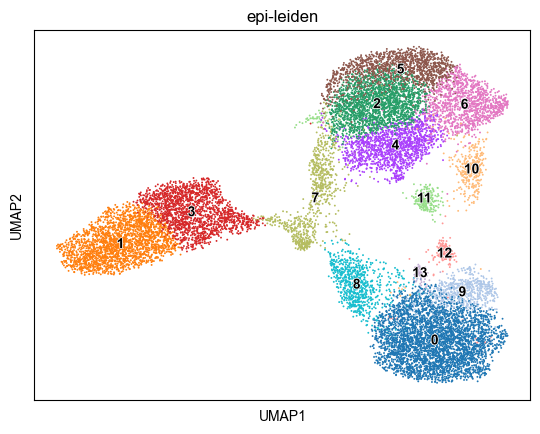

In [8]:
adata_epi_norm = clu(adata_epi_norm, 'epi-leiden', n_pcs=30, do_har=True)

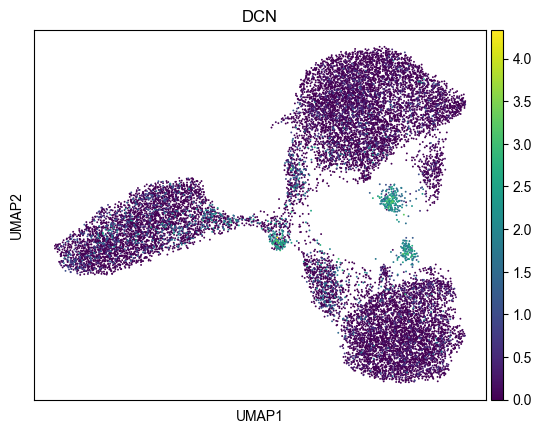

In [9]:
sc.pl.umap(adata_epi_norm, color=['DCN'])

2024-12-06 08:41:49,978 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Ignoring processing doublet cells...


2024-12-06 08:42:08,381 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-06 08:42:08,503 - harmonypy - INFO - Iteration 1 of 20
2024-12-06 08:42:14,542 - harmonypy - INFO - Iteration 2 of 20
2024-12-06 08:42:20,877 - harmonypy - INFO - Iteration 3 of 20
2024-12-06 08:42:26,904 - harmonypy - INFO - Converged after 3 iterations
/home/rzh/BCY/lib/python3.10/site-packages/scanpy/external/pp/_harmony_integrate.py:84: ImplicitModificationWarning: Setting element `.obsm['X_pca_harmony']` of view, initializing view as actual.
  adata.obsm[adjusted_basis] = harmony_out.Z_corr.T
/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


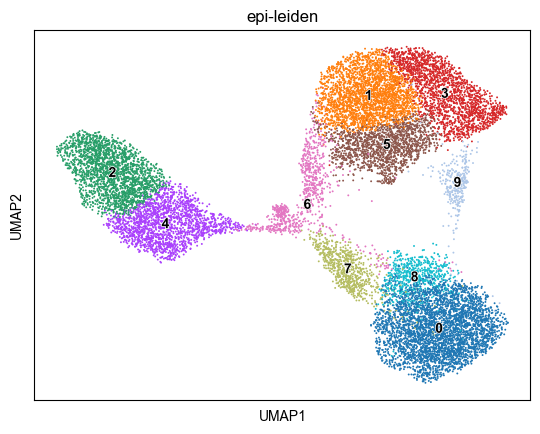

In [10]:
adata_epi_norm = adata_epi_norm[~adata_epi_norm.obs['epi-leiden'].isin(['11', '12', '13'])]
adata_epi_norm = clu(adata_epi_norm, 'epi-leiden', n_pcs=30, do_har=True, resolution=1)

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


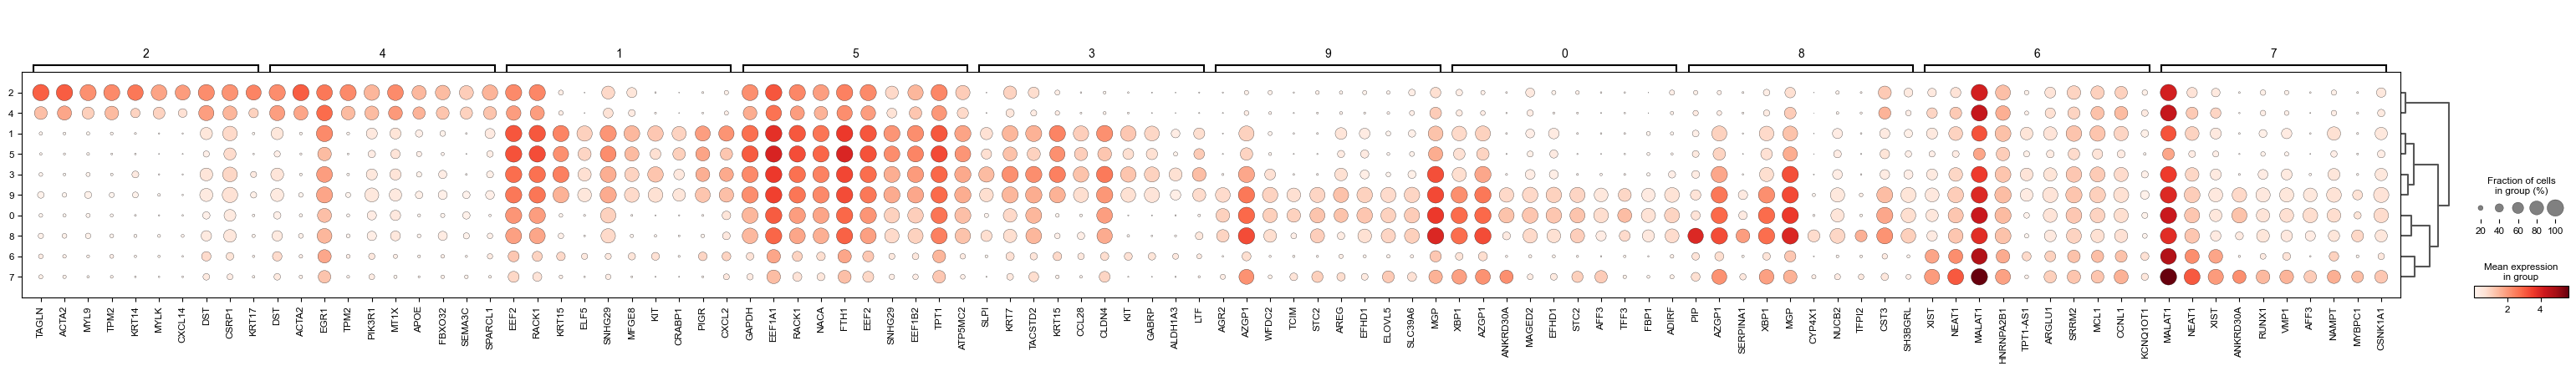

In [11]:
sc.tl.rank_genes_groups(adata_epi_norm, groupby='epi-leiden', method='wilcoxon')
sc.tl.dendrogram(adata_epi_norm, groupby='epi-leiden')
sc.pl.rank_genes_groups_dotplot(adata_epi_norm, groupby='epi-leiden')

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


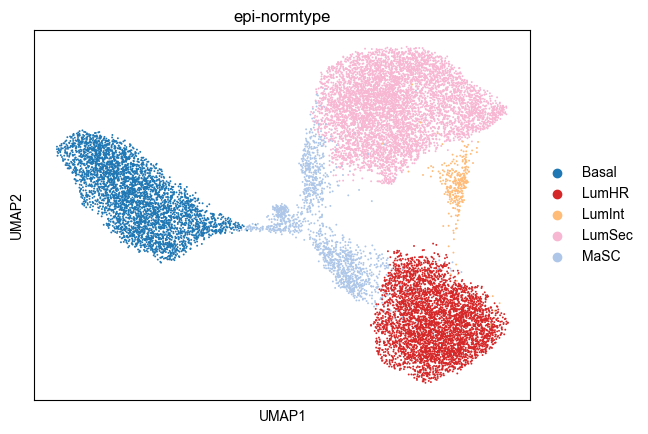

In [12]:
adata_epi_norm.obs['epi-normtype'] = 'MaSC'
adata_epi_norm.obs.loc[adata_epi_norm.obs['epi-leiden'].isin(['1', '3', '5']),'epi-normtype'] = 'LumSec'
adata_epi_norm.obs.loc[adata_epi_norm.obs['epi-leiden'].isin(['2', '4']),'epi-normtype'] = 'Basal'
adata_epi_norm.obs.loc[adata_epi_norm.obs['epi-leiden'].isin(['0', '8']),'epi-normtype'] = 'LumHR'
adata_epi_norm.obs.loc[adata_epi_norm.obs['epi-leiden'].isin(['9']),'epi-normtype'] = 'LumInt'
sc.pl.umap(adata_epi_norm, color=['epi-normtype'], palette=['#1f77b4', '#d62728', '#ffbb78', '#f7b6d2', '#aec7e8'])

In [13]:
adata_epi_norm.write_h5ad("adata-epi-norm-12.6.h5ad")

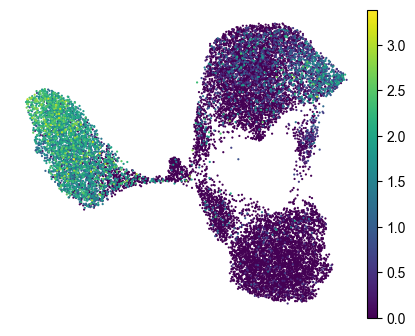

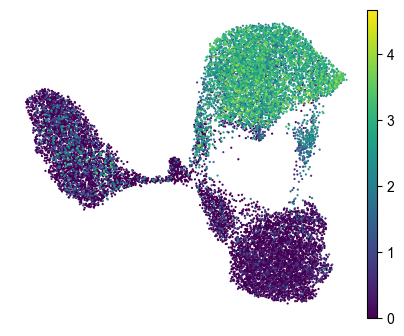

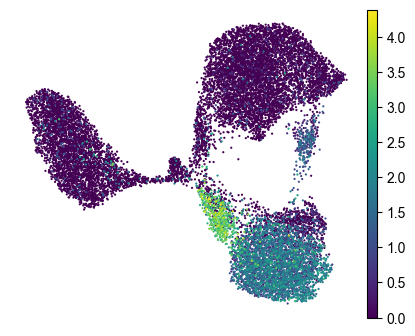

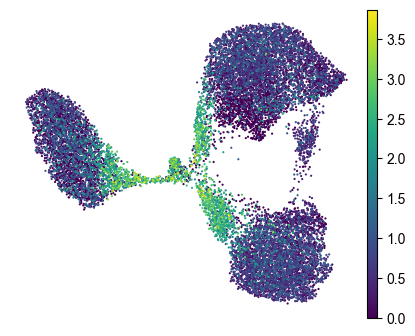

In [32]:
for gene in ['KRT5', 'KRT15', 'ANKRD30A', 'XIST']:
  fig, ax = plt.subplots(1, 1, figsize=(5, 4))
  sc.pl.umap(adata_epi_norm, color=gene,size=10, ax=ax, title='',show=False)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.set_xlabel("")
  ax.set_ylabel("")
  # ax.legend(  handletextpad=0.5, frameon=False,
  #                     borderpad=0.6,
  #                     columnspacing=1.3,
  #                     handlelength=0.65, fontsize=12)
  fig.savefig(f"{figpath}/S1f-{gene}.png", dpi=400, bbox_inches='tight')

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


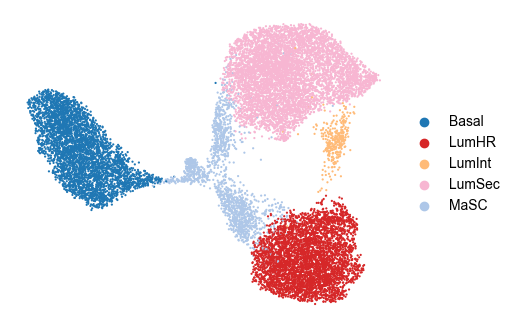

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sc.pl.umap(adata_epi_norm, color=['epi-normtype'],size=10, ax=ax, title='',show=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel("")
ax.set_ylabel("")
# ax.legend(  handletextpad=0.5, frameon=False,
#                     borderpad=0.6,
#                     columnspacing=1.3,
#                     handlelength=0.65, fontsize=12)
fig.savefig(f"{figpath}/1e-normtype.png", dpi=400, bbox_inches='tight')

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


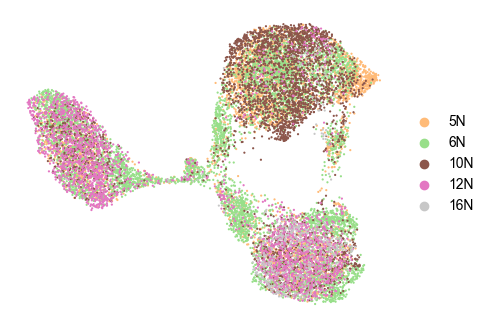

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sc.pl.umap(adata_epi_norm, color=['batch'],size=10, ax=ax, title='',show=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel("")
ax.set_ylabel("")
# ax.legend(  handletextpad=0.5, frameon=False,
#                     borderpad=0.6,
#                     columnspacing=1.3,
#                     handlelength=0.65, fontsize=12)
fig.savefig(f"{figpath}/S1h-batch.png", dpi=400, bbox_inches='tight')

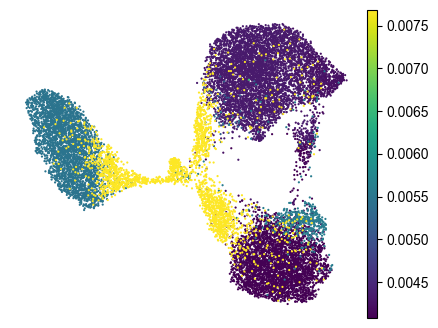

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sc.pl.umap(adata_epi_norm, color=['cnv_score'],size=10, ax=ax, title='',show=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel("")
ax.set_ylabel("")
# ax.legend(  handletextpad=0.5, frameon=False,
#                     borderpad=0.6,
#                     columnspacing=1.3,
#                     handlelength=0.65, fontsize=12)
fig.savefig(f"{figpath}/S1i-cnv.png", dpi=400, bbox_inches='tight')

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


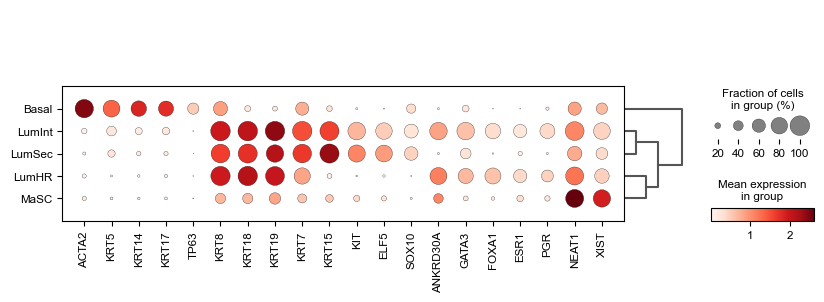

In [66]:
sc.pl.dotplot(adata_epi_norm, var_names=['ACTA2','KRT5', 'KRT14', 'KRT17','TP63', 'KRT8', 'KRT18', 'KRT19',  'KRT7','KRT15',
                                          'KIT','ELF5','SOX10','ANKRD30A','GATA3','FOXA1','ESR1','PGR', 'NEAT1', 'XIST'], groupby='epi-normtype', dendrogram=True, save='_epikrt1.svg')

In [44]:
def propPlot(age_df, barlabels, ax, colors=sc.pl.palettes.default_20, xlabel='Patient ID', show_y=True, xrotate=90):
    all_df = age_df.sum(axis=1)
    age_normdf = pd.DataFrame([age_df.loc[i,:]/all_df[i] for i in barlabels], index=barlabels)
    age_cumdf = pd.DataFrame([np.cumsum(age_normdf.loc[i,:]) for i in barlabels], index=barlabels)
    norm_gdfs = age_normdf
    cum_gdfs = age_cumdf
    for i, col in enumerate(age_df.columns):
        height = norm_gdfs[col]
        starts = cum_gdfs[col] - height
        rects = ax.bar(barlabels, height, bottom=starts, width=0.9, color=colors[i], edgecolor='white', linewidth=0.5,
                        label=col, alpha=1)
    
        # ax.bar_label(rects,age_df.loc[:, col], label_type='center', color='lightgrey', fontsize=14)
    ax.legend( bbox_to_anchor=(1, -0.3), 
              handletextpad=0.5, frameon=False,
                          borderpad=0.4,
                          columnspacing=1,
                          handlelength=0.65,
              loc='lower left')
    if show_y:
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
        ax.set_ylabel('Cell proportions')
    else:
        ax.yaxis.set_visible(False)
        ax.spines.left.set_visible(False)
    ax.set_xlabel(xlabel)
    ax.set_xticks(barlabels)
    ax.set_xticklabels(labels=barlabels,rotation=xrotate)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)

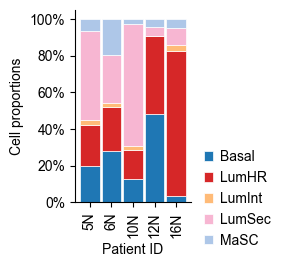

In [45]:
barlabels = ['5N', '6N', '10N', '12N','16N']
cell_types = ['Basal','LumHR', 'LumInt', 'LumSec', 'MaSC']
# colors = pd.Series(sc.pl.palettes.default_20[:9], index=adata.obs['majorType-fix'].cat.categories)
colors = ['#1f77b4', '#d62728','#ffbb78','#f7b6d2','#aec7e8']
age_df = pd.DataFrame(columns = list(cell_types))
for bar in barlabels:
    d1 = pd.DataFrame([len(adata_epi_norm[(adata_epi_norm.obs["epi-normtype"] == ct) & (adata_epi_norm.obs["batch"] == bar)]) for ct in list(cell_types)], index = list(cell_types), columns=[bar]).T
    age_df = pd.concat([age_df, d1])
fig0, ax0 = plt.subplots(figsize=(1.5, 2.5))
propPlot(age_df, barlabels, ax0, colors=colors)
fig0.savefig(f"{figpath}/1g-proportions.svg",bbox_inches='tight')

In [69]:
adata = sc.read_h5ad('adata-GSE161529.h5ad')
adata

AnnData object with n_obs × n_vars = 33698 × 23936
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'leiden-major', 'major-type'
    var: 'ID', 'name', 'type', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dea_leiden-major', 'dendrogram_leiden-major', 'hvg', 'leiden-major', 'leiden-major_colors', 'log1p', 'major-type_colors', 'neighbors', 'pca', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [76]:
adata.obs['annotation'] = adata.obs['major-type']

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


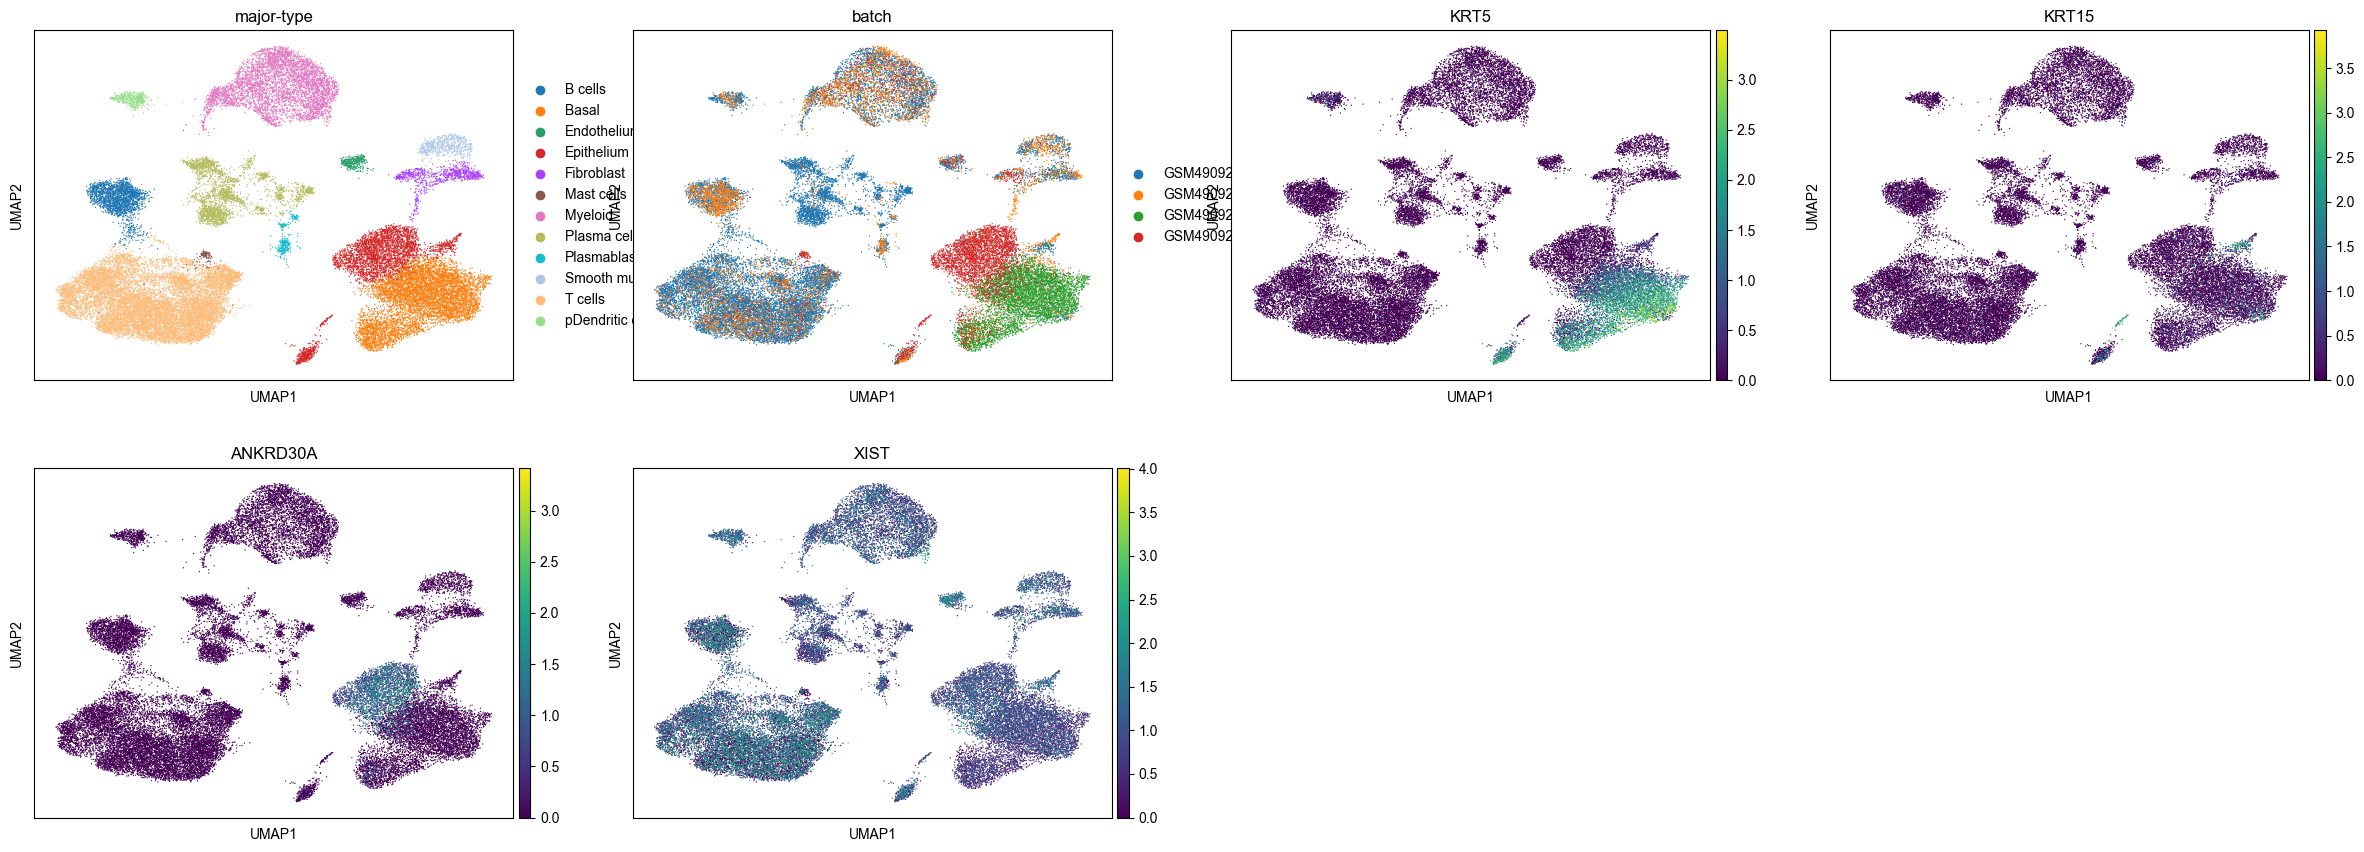

In [73]:
sc.pl.umap(adata, color=['major-type', 'batch', 'KRT5', 'KRT15', 'ANKRD30A', 'XIST'])

In [75]:
wdata = sc.read_h5ad("New_018.h5ad")

/home/rzh/BCY/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [106]:
adata_concat = adata_epi_cnv.concatenate([
  wdata[wdata.obs['annotation'].isin(['Cancer Basal', 'Cancer Epithelial', 'Normal Epithelial'])],
  adata[adata.obs['major-type'].isin(['Basal', 'Epithelium'])]
  ],
  batch_categories=['Young', 'Non-young','Young-inter'], batch_key='age')
adata_concat

/tmp/ipykernel_2878107/2537748471.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = adata_epi_cnv.concatenate([
/home/rzh/BCY/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/rzh/BCY/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/rzh/BCY/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 76702 × 17269
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'majorType-fix', 'cnv_leiden', 'cnv_score', 'cnv_status', 'IHC', 'epi-leiden', 'type', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'subtype', 'celltype_subset', 'celltype_minor', 'celltype_major', 'leiden-1', 'UCell_B cells', 'UCell_B cells memory', 'UCell_B cells naive', 'UCell_Basophils', 'UCell_Dendritic cells', 'UCell_Eosinophils', 'UCell_Erythroblasts', 'UCell_Erythroid-like and erythroid precursor cells', 'UCell_Gamma delta T cells', 'UCell_Macrophages', 'UCell_Mast cells', 'UCell_Megakaryocytes', 'UCell_Monocytes', 'UCell_Myeloid-derived suppressor cells', 'UCell_

In [107]:
adata_concat.obs = adata_concat.obs[['batch', 'age']]

Ignoring processing doublet cells...
Evaluating neighbors only...


/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


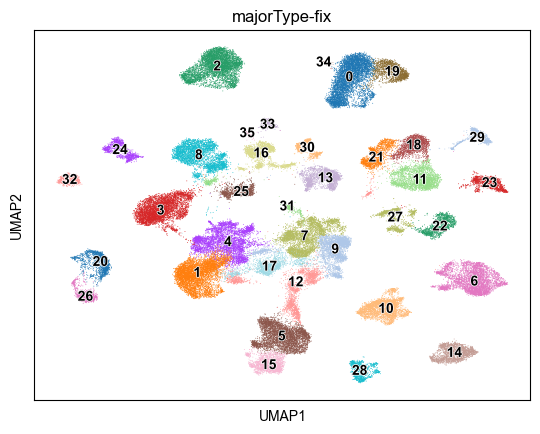

In [109]:
sc.pp.normalize_total(adata_concat)
sc.pp.log1p(adata_concat)
sc.pp.highly_variable_genes(adata_concat,min_disp=0.5, n_top_genes=2000)
adata_concat = clu(adata_concat, do_scrublet=False,  do_har=False, rep='X_pca')

Ignoring processing doublet cells...
Evaluating neighbors only...


/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


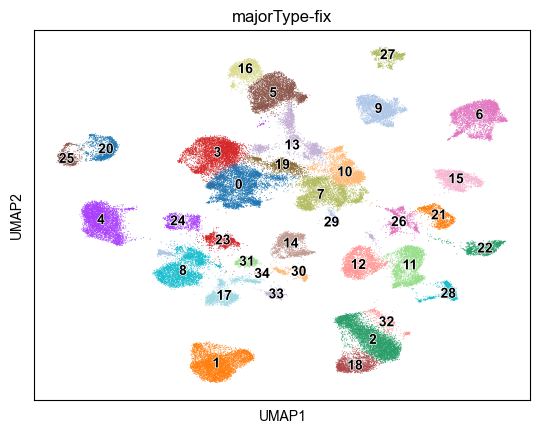

In [112]:
adata_concat = clu(adata_concat, do_scrublet=False,  do_har=False, rep='X_pca', n_pcs=25)

Ignoring processing doublet cells...
Evaluating neighbors only...


/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


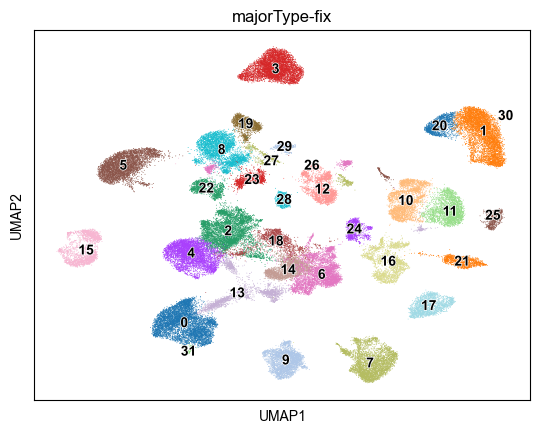

In [113]:
adata_concat = clu(adata_concat, do_scrublet=False,  do_har=False, rep='X_pca', n_pcs=20)

Ignoring processing doublet cells...
Evaluating neighbors only...


/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


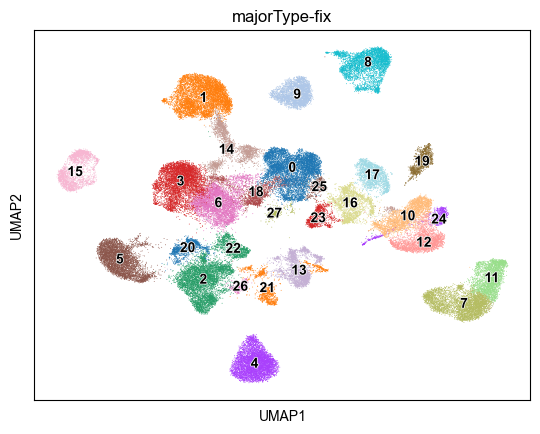

In [116]:
adata_concat = clu(adata_concat, do_scrublet=False,  do_har=False, rep='X_pca', n_pcs=15)

In [117]:
adata_concat.write_h5ad('adata-epi-concat-12.5.h5ad')

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


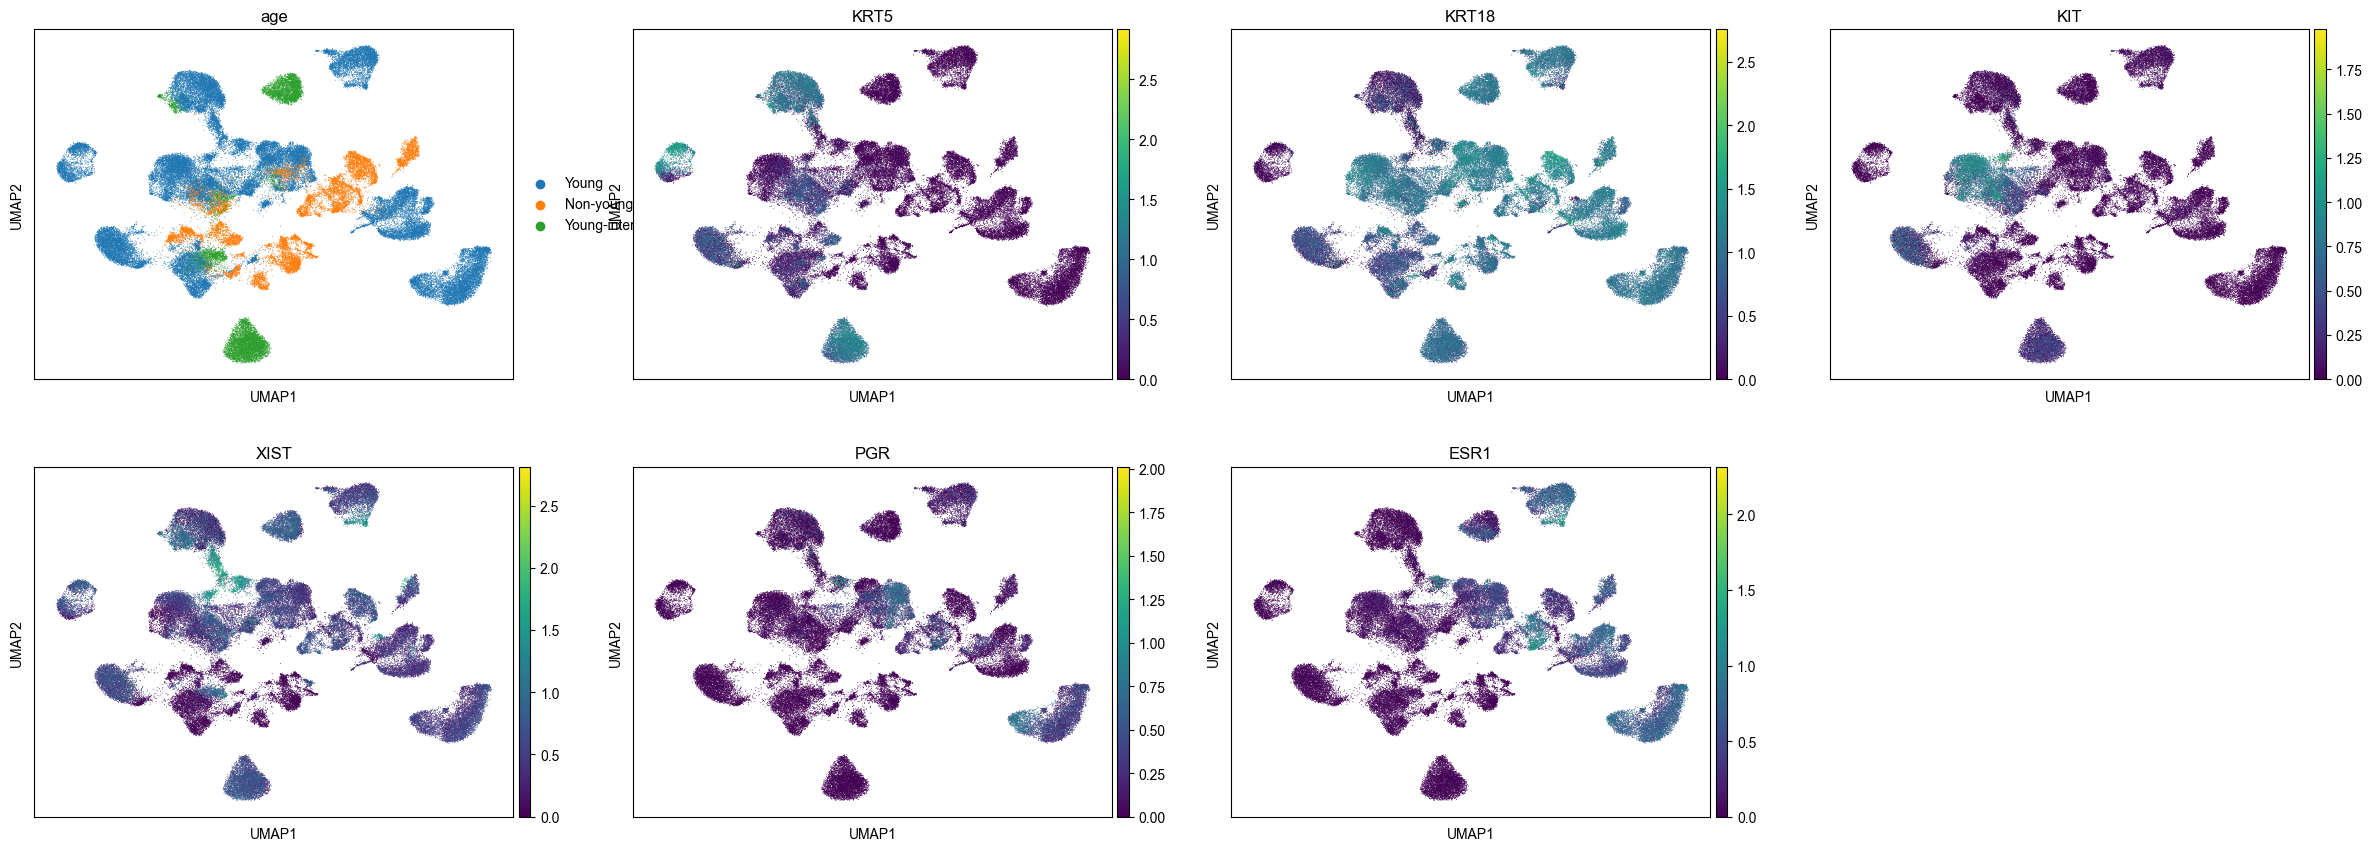

In [122]:
sc.pl.umap(adata_concat, color=['age', 'KRT5', 'KRT18', 'KIT', 'XIST', 'PGR', 'ESR1'])

In [ ]:
import infercnvpy as cnv 
import pandas as pd
chrom = pd.read_csv("gene_pos.txt", sep='\t', header=None)
chrom.columns = ["symbol", "ensg", "chromosome", "start", "end"]
chrom.index = chrom['symbol']
chrom['ensg'] = [name.split('.')[0] for name in chrom['ensg']]
chrom_ensg = chrom.copy()
chrom_ensg.index = chrom_ensg['ensg']
var_names = list(adata_concat.var_names[adata_concat.var_names.isin(chrom['symbol']) + adata_epi.var_names.isin(chrom['ensg'])])
adata_epi_var = adata_concat[:, var_names]
adata_epi_var = adata_concat[:, var_names]
for i in range(len(var_names)):
    name = var_names[i]
    if name in chrom_ensg['ensg']:
        var_names[i] = chrom_ensg['symbol'][name]
adata_epi_var.var_names = var_names
chrom_var_names = chrom.loc[var_names, :]
adata_concat_cnv = adata_concat[:, adata_concat.var_names.isin(chrom['symbol']) + adata_concat.var_names.isin(chrom['ensg'])]
adata_concat_cnv.var_names = var_names
adata_concat_cnv.var = pd.concat([adata_epi_var.var, chrom_var_names], axis=1)
adata_concat_cnv.var_names_make_unique()
cnv.tl.infercnv(adata_concat_cnv,reference_key="molecular_type", reference_cat=['Normal'])
cnv.tl.pca(adata_concat_cnv) 
cnv.pp.neighbors(adata_concat_cnv) 
cnv.tl.leiden(adata_concat_cnv)
cnv.tl.umap(adata_concat_cnv) 
cnv.tl.cnv_score(adata_concat_cnv)

In [124]:
sc.tl.rank_genes_groups(adata_concat, groupby='age', method='wilcoxon')

In [ ]:
import pandas as pd
import numpy as np
def get_expr(adata, groupby, groups=None):
  if groups is None:
    groups = adata.obs[groupby].unique()
  expr_df = pd.DataFrame(columns=groups)
  for ct in groups:
      expr = np.array(adata[adata.obs[groupby]==ct].X.mean(axis=0)).flatten()
      expr_df[ct] = exprgroups

  frac_df = pd.DataFrame(columns=groups)
  for ct in groups:
      frac = np.array(np.mean(adata[adata.obs[groupby]==ct].X > 1, axis=0)).flatten()
      frac_df[ct] = frac
  return expr_df, frac_df